# VAE paper-to-code ワークフロー

このノートブックは、論文のVAE実装を素早く動かしながら理解するためのチェックリスト付きハブです。上から順に実行していけば、環境構築から可視化・拡張までを一貫して進められます。

## チェックリスト概要
- [ ] 1. 環境準備：Python + PyTorch + データセット
- [ ] 2. コード最小実装を理解する（Encoder / Reparameterization / Decoder / ELBO）
- [ ] 3. 学習ループを走らせて loss を確認する
- [ ] 4. 生成画像・再構成・潜在可視化を保存する
- [ ] 5. ハイパーパラメータを変えて比較・記録する
- [ ] 6. 結果をドキュメント化し共有する

## 1. 環境準備
GPU (RTX3070/4070 など) を持つ環境で PyTorch が CUDA を正しく認識しているかをまず確認します。ノートブックの実行前に `python -m venv` や conda などで仮想環境を作成しておくと管理が楽です。

In [1]:
from pathlib import Path
import os

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name != "vae-paper-to-code" and (PROJECT_ROOT / "vae-paper-to-code").exists():
    PROJECT_ROOT = PROJECT_ROOT / "vae-paper-to-code"
PROJECT_ROOT = PROJECT_ROOT.resolve()
DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Exists src?: {(PROJECT_ROOT / 'src').exists()}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"REPORTS_DIR: {REPORTS_DIR}")

PROJECT_ROOT: /home/user/vae-paper-to-code/notebooks
Exists src?: False
DATA_DIR: /home/user/vae-paper-to-code/notebooks/data
REPORTS_DIR: /home/user/vae-paper-to-code/notebooks/reports


In [2]:
import platform
import torch

print(f"Python  : {platform.python_version()}")
print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    for idx in range(torch.cuda.device_count()):
        print(f"  - GPU{idx}: {torch.cuda.get_device_name(idx)}")
else:
    print("GPUが利用できません。CPUでの実行は可能ですが時間がかかります。")

Python  : 3.11.13
PyTorch : 2.8.0+cu128
CUDA    : True
  - GPU0: NVIDIA GeForce RTX 3070


### 追加ライブラリのインストール (必要に応じて)
依存関係が未インストールの場合は、以下のセルで `pip` を実行します。既に整っていればスキップしてください。

In [3]:
import sys
import subprocess

# 実行例: requirements.txt を一括インストール
# subprocess.run([sys.executable, "-m", "pip", "install", "-r", str(PROJECT_ROOT / "requirements.txt")], check=True)

print("必要に応じて上のコメントを外して実行してください。")

必要に応じて上のコメントを外して実行してください。


## 2. データセットを準備
MNIST (論文と同じ小規模データセット) をローカルにダウンロードし、存在を確認します。トーチビジョンが使えない場合はローカル実装 (`src/utils/mnist.py`) に自動でフォールバックします。

In [4]:
from typing import Tuple

try:
    from torchvision import datasets, transforms
    USE_TORCHVISION = True
except Exception as e:
    print(f"torchvision が利用できないためローカルローダーを使用します: {e}")
    USE_TORCHVISION = False

if USE_TORCHVISION:
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.MNIST(root=str(DATA_DIR), train=True, download=True, transform=transform)
    test_ds = datasets.MNIST(root=str(DATA_DIR), train=False, download=True, transform=transform)
    input_shape = train_ds[0][0].shape
else:
    from src.utils.mnist import MNISTLocal
    train_ds = MNISTLocal(root=str(DATA_DIR), train=True)
    test_ds = MNISTLocal(root=str(DATA_DIR), train=False)
    input_shape = train_ds[0][0].shape

print(f"train size: {len(train_ds)}, test size: {len(test_ds)}, input shape: {input_shape}")

100%|██████████| 9.91M/9.91M [00:10<00:00, 955kB/s] 

100%|██████████| 28.9k/28.9k [00:00<00:00, 171kB/s]

100%|██████████| 1.65M/1.65M [00:01<00:00, 1.63MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 6.62MB/s]

train size: 60000, test size: 10000, input shape: torch.Size([1, 28, 28])


/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIF

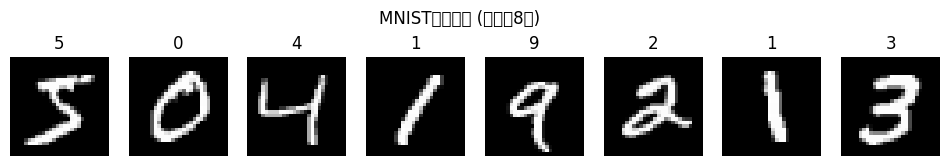

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for ax, (img, label) in zip(axes, [train_ds[i] for i in range(8)]):
    img_to_plot = img.squeeze().numpy()
    ax.imshow(img_to_plot, cmap="gray")
    ax.axis("off")
    ax.set_title(str(label))
plt.suptitle("MNISTサンプル (最初の8枚)")
plt.show()

## 3. コード最小実装の確認
既に `src/vae.py` と `src/train.py` に Encoder / Reparameterization / Decoder / ELBO が実装済みです。この節では設定を読み込み、モデル規模をざっくり把握します。詳細を追いたい場合は該当ファイルを VS Code で開いて参照してください。

In [7]:
from dataclasses import asdict
from src.vae import VAE, VAEConfig

cfg = VAEConfig()
model = VAE(cfg)
print(cfg)
print(f"parameter count: {sum(p.numel() for p in model.parameters()):,}")

ModuleNotFoundError: No module named 'src'

## 4. 学習ジョブのセットアップ
ここでハイパーパラメータを定義し、後続のセルでトレーニングを実行します。`device='auto'` にしておくと CUDA → MPS → CPU の順で自動選択されます。

In [ ]:
TRAINING_CONFIG = {
    "epochs": 10,
    "batch_size": 128,
    "latent_dim": 2,
    "hidden_dim": 400,
    "loss": "bce",
    "beta": 1.0,
    "beta_schedule": "none",
    "reduction": "mean",
    "lr": 1e-3,
    "device": "auto",
    "seed": 42,
    "project_dir": "reports",
    "group": "",  # 未指定なら自動生成 (mnist-latXX-...)
    "name": "",   # 未指定なら seed{seed} に日付プリフィックスが付く
    "num_workers": 4,
    "persistent_workers": False,
    "no_pin": False,
    "save_weights": True,
    "wandb": False,
    "wandb_mode": "disabled",
}

TRAINING_CONFIG

In [ ]:
import json
import os
import shlex
import subprocess
from copy import deepcopy

def _to_cli_flag(key: str) -> str:
    return "--" + key.replace("_", "-")

def run_training(config: dict) -> dict:
    args = ["python", "-m", "src.train"]
    for key, value in config.items():
        if isinstance(value, bool):
            if value:
                args.append(_to_cli_flag(key))
        elif value is None or value == "":
            continue
        else:
            args.extend([_to_cli_flag(key), str(value)])

    print("実行コマンド:")
    print(" \
,
,
,


    return locate_latest_run(config)

def _auto_group_name(config: dict) -> str:
    if config.get("group"):
        return config["group"]
    return (
        f"mnist-lat{config['latent_dim']}-"
        f"{config.get('loss', 'bce')}"
        f"-beta{config.get('beta', 1.0):g}-"
        f"{config.get('beta_schedule', 'none')}-"
        f"{config.get('reduction', 'mean')}"
    )

def locate_latest_run(config: dict) -> dict:
    project_dir = config.get("project_dir", "reports")
    group = _auto_group_name(config)
    group_dir = (PROJECT_ROOT / project_dir / group).resolve()
    latest_link = group_dir / "latest"
    run_dir = None
    if latest_link.is_symlink():
        target = os.readlink(latest_link)
        run_dir = (group_dir / target).resolve()
    elif latest_link.exists():
        target = latest_link.read_text().strip()
        candidate = (group_dir / target).resolve()
        if candidate.exists():
            run_dir = candidate

    if run_dir is None:
        candidates = sorted(group_dir.glob("*/run_meta.json"), key=lambda p: p.stat().st_mtime, reverse=True)
        if candidates:
            run_dir = candidates[0].parent

    if run_dir is None or not run_dir.exists():
        raise FileNotFoundError("run_meta.json が見つかりませんでした。コマンドの標準出力をご確認ください。")

    meta_path = run_dir / "run_meta.json"
    if meta_path.exists():
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)
    else:
        meta = {"run_dir": str(run_dir)}

    meta["run_dir"] = str(run_dir)
    return meta

### トレーニングを実行
上記設定を確認したら次のセルを実行してください。10エポック (数分) で loss の減少と生成画像を保存できます。GPU が利用できると高速です。

In [ ]:
latest_meta = run_training(TRAINING_CONFIG)
latest_meta

## 5. 結果の可視化
トレーニング出力 (`reports/<group>/<run>/`) を読み込み、損失曲線・再構成・生成サンプルを確認します。

In [ ]:
import pandas as pd

RUN_DIR = Path(latest_meta["run_dir"]).resolve()
print(f"Run dir: {RUN_DIR}")
print(f"Available entries: {[p.name for p in RUN_DIR.iterdir()]}")

In [ ]:
log_path = RUN_DIR / "curves" / "train_log.csv"
df = pd.read_csv(log_path)
df.head()

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(df["epoch"], df["recon"], label="recon")
plt.plot(df["epoch"], df["kl"], label="kl")
plt.plot(df["epoch"], df["total"], label="total")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ELBO components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display
from PIL import Image

def show_latest_image(subdir: str):
    target_dir = RUN_DIR / subdir
    files = sorted(target_dir.glob("*.png"))
    if not files:
        print(f"{subdir} に画像がありませんでした。")
        return
    latest = files[-1]
    print(f"{subdir}: {latest.name}")
    display(Image.open(latest))

show_latest_image("reconstructions")
show_latest_image("samples")
show_latest_image("traversals")

### 潜在空間の散布図 (latent_dim=2 の場合)
チェックポイントを保存している場合は、テストデータをエンコードして潜在空間を可視化できます。

In [ ]:
import torch
from torch.utils.data import DataLoader
from src.vae import VAE, VAEConfig

ckpts = sorted(RUN_DIR.glob("vae_epoch_*.pt"))
if not ckpts:
    print("チェックポイントが存在しません。TRAINING_CONFIG['save_weights']=True で再学習すると生成されます。")
else:
    ckpt_path = ckpts[-1]
    print(f"loading checkpoint: {ckpt_path.name}")
    payload = torch.load(ckpt_path, map_location="cpu")
    cfg = VAEConfig(**payload["cfg"])
    model = VAE(cfg)
    model.load_state_dict(payload["model_state"])
    model.eval()

    loader = DataLoader(test_ds, batch_size=256, shuffle=False)
    zs, ys = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.view(x.size(0), -1)
            mu, logvar = model.encode(x)
            zs.append(mu)
            ys.append(y)
    z_all = torch.cat(zs).cpu().numpy()
    y_all = torch.cat(ys).cpu().numpy()

    if z_all.shape[1] != 2:
        print(f"latent_dim={z_all.shape[1]} のため 2D 可視化をスキップします。")
    else:
        plt.figure(figsize=(5, 5))
        scatter = plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap="tab10", s=8, alpha=0.6)
        plt.colorbar(scatter, ticks=range(10))
        plt.title("潜在空間 (μ) の散布図")
        plt.xlabel("z1")
        plt.ylabel("z2")
        plt.grid(True)
        plt.show()

## 6. 軽い拡張タスク
`latent_dim` を {2, 10, 20} で変えて比較するなど、追加実験を効率化するヘルパーを用意しました。時間に余裕があるときに実行してください。

In [ ]:
def sweep_latent_dims(base_config: dict, latent_dims=(2, 10, 20)):
    results = []
    for lat in latent_dims:
        cfg = deepcopy(base_config)
        cfg["latent_dim"] = lat
        cfg["name"] = f"lat{lat}"
        meta = run_training(cfg)
        results.append((lat, meta["run_dir"]))
    return results

# 例: 実行する場合は以下のコメントを外してください (合計時間に注意)
# sweep_results = sweep_latent_dims(TRAINING_CONFIG)
# sweep_results

## 7. 次のステップ
- Hydra や YAML でハイパーパラメータを外部管理する
- `reports/` に保存された画像やログを README や HuggingFace Spaces で共有する
- 理論面で気になる式を論文と突き合わせる

このノートブックを使えば、短期目標リストを上から順に実行しながら結果を蓄積できます。必要に応じてセルを複製し、追加の記録メモを挿入してください。